# Rotation CIFAR Experiment

This experiment will use images from the **CIFAR-100** database (https://www.cs.toronto.edu/~kriz/cifar.html) and showcase the backward transfer efficiency of algorithms in the **Progressive Learning** project (https://github.com/neurodata/progressive-learning) as the images are rotated.

In [1]:
# Import the packages for experiment
import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import random
from skimage.transform import rotate
from scipy import ndimage
from skimage.util import img_as_ubyte
from joblib import Parallel, delayed
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from itertools import product
import keras
from keras import layers
from joblib import Parallel, delayed
from multiprocessing import Pool
import tensorflow as tf
from numba import cuda
import seaborn as sns

In [2]:
# Import the progressive learning packages
from proglearn.network import LifelongClassificationNetwork
from proglearn.forest import LifelongClassificationForest

# Create array to store errors
errors_array = []

In [3]:
# Randomized selection of training and testing subsets
def cross_val_data(data_x, data_y, total_cls=10):
    # Creates copies of both data_x and data_y so that they can be modified without affecting the original sets
    x = data_x.copy()
    y = data_y.copy()
    # Creates a sorted array of arrays that each contain the indices at which each unique element of data_y can be found
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]
      
    for i in range(total_cls):
        # Chooses the i'th array within the larger idx array
        indx = idx[i]
        # The elements of indx are randomly shuffled
        random.shuffle(indx)
        
        if i==0:
            # 250 training data points per task
            train_x1 = x[indx[0:250],:]
            train_x2 = x[indx[250:500],:]
            train_y1 = y[indx[0:250]]
            train_y2 = y[indx[250:500]]
            
            # 100 testing data points per task
            test_x = x[indx[500:600],:]
            test_y = y[indx[500:600]]
        else:
            # 250 training data points per task
            train_x1 = np.concatenate((train_x1, x[indx[0:250],:]), axis=0)
            train_x2 = np.concatenate((train_x2, x[indx[250:500],:]), axis=0)
            train_y1 = np.concatenate((train_y1, y[indx[0:250]]), axis=0)
            train_y2 = np.concatenate((train_y2, y[indx[250:500]]), axis=0)
            
            # 100 testing data points per task
            test_x = np.concatenate((test_x, x[indx[500:600],:]), axis=0)
            test_y = np.concatenate((test_y, y[indx[500:600]]), axis=0)
        
    return train_x1, train_y1, train_x2, train_y2, test_x, test_y 

# Algorithms

The progressive-learning repo contains two main algorithms, **Lifelong Learning Forests** (L2F) and **Lifelong Learning Network** (L2N), within `forest.py` and `network.py`, respectively. The main difference is that L2F uses random forests while L2N uses deep neural networks. Both algorithms, unlike LwF, EWC, Online_EWC, and SI, have been shown to achieve both forward and backward knowledge transfer. Either algorithm can be chosen for the purpose of this experiment.

# Experiment

If the chosen algorithm is trained on both straight up-and-down CIFAR images and rotated CIFAR images, rather than just straight up-and-down CIFAR images, will it perform better (achieve a higher backward transfer efficiency) when tested on straight up-and-down CIFAR images? How does the angle at which training images are rotated affect these results?

At a rotation angle of 0 degrees, the rotated images simply provide additional straight up-and-down CIFAR training data, so the backward transfer efficiency at this angle show whether or not the chosen algorithm can even achieve backward knowledge transfer. As the angle of rotation increases, the rotated images become less and less similar to the original dataset, so the backward transfer efficiency should logically decrease, while still being above 1.

In [4]:
# Chooses model to use as transformer
def choose_transformer(train_x1, test_x, test_y, tmp_data):
    
    # Deep Neural Networks model is used as transformer
    if model == "dnn":

        # Transformer network used to map input to output
        network = keras.Sequential()
        network.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=np.shape(train_x1)[1:]))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=254, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))

        network.add(layers.Flatten())
        network.add(layers.BatchNormalization())
        network.add(layers.Dense(2000, activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Dense(2000, activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Dense(units=10, activation = 'softmax'))
        
        return (train_x1, test_x, tmp_data, network)

    # Lifelong Classification Forest model is used as transformer
    elif model == "lf":

        # .shape gives the dimensions of each numpy array
        # .reshape gives a new shape to the numpy array without changing its data
        train_x1 = train_x1.reshape((train_x1.shape[0], train_x1.shape[1] * train_x1.shape[2] * train_x1.shape[3]))
        tmp_data = tmp_data.reshape((tmp_data.shape[0], tmp_data.shape[1] * tmp_data.shape[2] * tmp_data.shape[3]))
        test_x = test_x.reshape((test_x.shape[0], test_x.shape[1] * test_x.shape[2] * test_x.shape[3]))
        
        return (train_x1, test_x, tmp_data)

In [5]:
# Runs the experiments
def LF_experiment(data_x, data_y, angle, model, granularity, max_depth, reps=1, ntrees=29, acorn=None):
    
    # Set random seed to acorn if acorn is specified
    if acorn is not None:
        np.random.seed(acorn)
    
    errors = np.zeros(2) # initializes array of errors that will be generated during each rep
    
    with tf.device('/gpu:'+str(int(angle //  granularity) % 4)):
        for rep in range(reps):
            print("rep:{}".format(rep)) # Allows user to track the progress of the notebook while the experiment is running
            
            # training and testing subsets are randomly selected by calling the cross_val_data function
            train_x1, train_y1, train_x2, train_y2, test_x, test_y = cross_val_data(data_x, data_y, total_cls=10)

            # Change data angle for second task
            tmp_data = train_x2.copy()
            _tmp_ = np.zeros((32,32,3), dtype=int)
            total_data = tmp_data.shape[0]

            for i in range(total_data):
                tmp_ = image_aug(tmp_data[i],angle)
                # 2D image is flattened into a 1D array as random forests can only take in flattened images as inputs
                tmp_data[i] = tmp_
            
            if model == "lf": # random forests
                # Call function to choose model for transformer
                (train_x1, test_x, tmp_data) = choose_transformer(train_x1, test_x, test_y, tmp_data)
                # number of trees (estimators) to use is passed as an argument because the default is 100 estimators
                progressive_learner = LifelongClassificationForest(n_estimators = ntrees, default_max_depth = max_depth)
            elif model == "dnn": # deep net
                # Call function to choose model for transformer
                (train_x1, test_x, tmp_data, network) = choose_transformer(train_x1, test_x, test_y, tmp_data)
                # network is passed as an argument so that LifelongClassificationNetwork knows which transformer network to use
                progressive_learner = LifelongClassificationNetwork(network = network)

            # Add the original task
            progressive_learner.add_task(X = train_x1, y = train_y1)

            # Predict and get errors for original task
            llf_single_task=progressive_learner.predict(test_x, task_id=0)
            
            # Add the new transformer
            progressive_learner.add_transformer(X = tmp_data, y = train_y2)

            # Predict and get errors with the new transformer
            llf_task1=progressive_learner.predict(test_x, task_id=0)

            errors[1] = errors[1]+(1 - np.mean(llf_task1 == test_y)) # errors from transfer learning
            errors[0] = errors[0]+(1 - np.mean(llf_single_task == test_y)) # errors from original task
    
    errors = errors/reps # errors are averaged across all reps ==> more reps means more accurate errors
    # Prints errors for each angle
    print("Errors For Angle {}: {}".format(angle, errors))
    
    # Average errors for original task and transfer learning are returned for the angle tested
    return(errors)

In [6]:
# Rotates the image by the given angle and zooms in to remove unnecessary white space at the corners
# Some image data is lost during rotation because of the zoom
def image_aug(pic, angle, centroid_x=23, centroid_y=23, win=16, scale=1.45):
    # Calculates scaled dimensions of image
    im_sz = int(np.floor(pic.shape[0]*scale))
    pic_ = np.uint8(np.zeros((im_sz,im_sz,3),dtype=int))
    
    # Uses zoom function from scipy.ndimage to zoom into the image
    pic_[:,:,0] = ndimage.zoom(pic[:,:,0],scale)
    pic_[:,:,1] = ndimage.zoom(pic[:,:,1],scale)
    pic_[:,:,2] = ndimage.zoom(pic[:,:,2],scale)
    
    # Rotates image using rotate function from skimage.transform
    image_aug = rotate(pic_, angle, resize=False)
    image_aug_ = image_aug[centroid_x-win:centroid_x+win,centroid_y-win:centroid_y+win,:]
    
    # Converts the image to unsigned byte format with values in [0, 255] and then returns it
    return img_as_ubyte(image_aug_)

# Hyperparameters

Hyperparameters determine how the model will run. Changing the value of `model` to `"lf"` will run the L2F algorithm, while `"dnn"` will run the L2N algorithm.

`granularity` refers to the amount by which the angle will be increased each time. Setting this value at 1 will cause the algorithm to test every whole number rotation angle between 0 and 180 degrees.

`reps` refers to the number of repetitions tested for each angle of rotation. For each repetition, the data is randomly resampled.

`max_depth` refers to the maximum depth of each tree in the Lifelong Classification Forest. If this value is not specified, LifelongClassificationForest defaults to a max tree depth of 30.

In [7]:
### MAIN HYPERPARAMS ###
model = "lf"
granularity = 45
reps = 75
max_depth = 5
########################

In [8]:
# Loads and reshapes data sets
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()
# Joins the training and testing arrays into one
data_x = np.concatenate([X_train, X_test]) 
data_y = np.concatenate([y_train, y_test]) 
data_y = data_y[:, 0]

In [9]:
# Runs the experiment at a new angle of rotation
def perform_angle(angle):
    error_list = LF_experiment(data_x, data_y, angle, model, granularity, max_depth, reps=reps, ntrees=16, acorn=1)
    
    # Returns a single array for each angle containing the original error and transfer learning error
    return(error_list)

In [10]:
# Run L2N
if model == "dnn":
    for angle_adder in range(0, 181, granularity * 4):
        angles = angle_adder + np.arange(0, granularity * 4, granularity)
        # Parallel processing
        with Pool(4) as p:
            # Multiple sets of errors for each set of angles are appended to a larger array containing errors for all angles
            errors_array.append(p.map(perform_angle, angles))
            
# Run L2F
elif model == "lf":
    # Generate set of angles to test for BTE
    angles = np.arange(0, 181, granularity)
    # Parallel processing
    with Pool(8) as p:
        # Multiple sets of errors for each set of angles are appended to a larger array containing errors for all angles
        errors_array.append(p.map(perform_angle, angles))

rep:0rep:0rep:0rep:0

rep:0


rep:1
rep:1
rep:1
rep:1
rep:1
rep:2
rep:2
rep:2
rep:2
rep:2
rep:3
rep:3
rep:3
rep:3
rep:3
rep:4
rep:4
rep:4
rep:4
rep:4
rep:5
rep:5
rep:5
rep:5
rep:5
rep:6
rep:6
rep:6
rep:6
rep:6
rep:7
rep:7
rep:7
rep:7
rep:7
rep:8
rep:8
rep:8
rep:8
rep:8
rep:9
rep:9
rep:9
rep:9
rep:9
rep:10
rep:10
rep:10
rep:10
rep:10
rep:11
rep:11
rep:11
rep:11
rep:11
rep:12
rep:12
rep:12
rep:12
rep:12
rep:13
rep:13
rep:13
rep:13
rep:13
rep:14
rep:14
rep:14
rep:14
rep:14
rep:15
rep:15
rep:15
rep:15
rep:15
rep:16
rep:16
rep:16
rep:16
rep:16
rep:17
rep:17
rep:17
rep:17
rep:17
rep:18
rep:18
rep:18
rep:18
rep:18
rep:19
rep:19
rep:19
rep:19
rep:19
rep:20
rep:20
rep:20
rep:20
rep:20
rep:21
rep:21
rep:21
rep:21
rep:21
rep:22
rep:22
rep:22
rep:22
rep:22
rep:23
rep:23
rep:23
rep:23
rep:23
rep:24
rep:24
rep:24
rep:24
rep:24
rep:25
rep:25
rep:25
rep:25
rep:25
rep:26
rep:26
rep:26
rep:26
rep:26
rep:27
rep:27
rep:27
rep:27
rep:27
rep:28
rep:28
rep:28
rep:28
rep:28
rep:29
rep:29
rep:29
rep:29
rep:29


# Rotation CIFAR Plot

This section takes the results of the experiment and plots the backward transfer efficiency against the angle of rotation for the images in **CIFAR-100**.

# Expected Results

If done correctly, the plot should show that Backward Transfer Efficiency (BTE) is greater than 1 regardless of rotation, but the BTE should decrease as the angle of rotation is increased. The more the number of reps and the finer the granularity, the smoother this downward sloping curve should look.

In [11]:
# Choose which algorithms to plot
alg_name = ['L2F']#['L2N']
tes = [[] for _ in range(len(alg_name))]

# Calculate BTE for each angle of rotation for each algorithm
for algo_no,alg in enumerate(alg_name):
    for angle in angles:
        orig_error, transfer_error = errors_array[0][int(angle/granularity)] # (angle/granularity) gives the index of the errors for that angle
        tes[algo_no].append(orig_error / transfer_error) # (original error/transfer error) gives the BTE

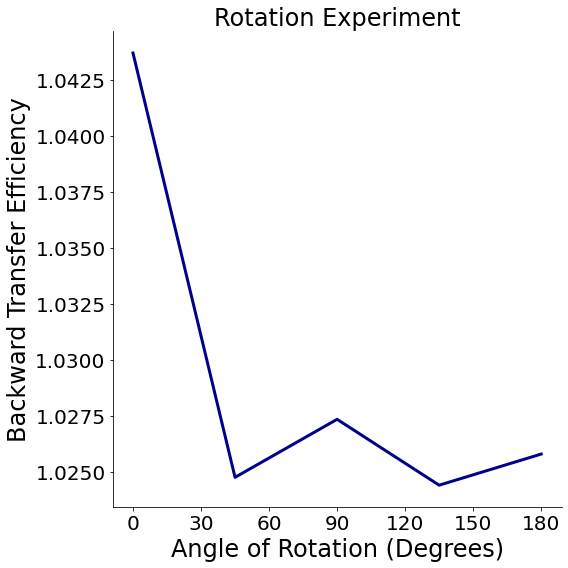

In [12]:
# Choose which color to make each algorithm's results
clr = ["#00008B"]#["#e41a1c"]
c = sns.color_palette(clr, n_colors=len(clr))
fig, ax = plt.subplots(1,1, figsize=(8,8))

# Plot the data
for alg_no,alg in enumerate(alg_name):
    if alg_no<2:
        ax.plot(angles,tes[alg_no], c=c[alg_no], label=alg_name[alg_no], linewidth=3)
    else:
        ax.plot(angles,tes[alg_no], c=c[alg_no], label=alg_name[alg_no])

# Format and label the plot
ax.set_xticks([0,30,60,90,120,150,180])
ax.tick_params(labelsize=20)
ax.set_xlabel('Angle of Rotation (Degrees)', fontsize=24)
ax.set_ylabel('Backward Transfer Efficiency', fontsize=24)
ax.set_title("Rotation Experiment", fontsize = 24)
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.tight_layout()
#x.legend(fontsize = 24)
plt.show()

# FAQs

### Why am I getting an "out of memory" error?
`Pool(8)` in the previous cell allows for parallel processing, so the number within the parenthesis should be, at max, the number of cores in the device on which this notebook is being run. Even if a warning is produced, the results of the experimented should not be affected.

### Why is this taking so long to run? How can I speed it up to see if I am getting the expected outputs?
Decreasing the value of `reps` or increasing the value of `granularity` will both decrease runtime at the cost of noisier results.